![](https://live.staticflickr.com/5009/5277522498_7646c3b586_z.jpg)

# Energy Efficiency

This project aims to study the relationships between physical parameters of buildings and the power required to cool and heat them. The goal is to build machine learning models to predict these energy variables. This topic is important because it is directly related to energy efficiency, which is a critical issue in the current context of energy generation and consumption within a country. The dataset used in this study was constructed by the [Center of Machine Learning and Intelligent Systems](https://cml.ics.uci.edu/) in Irvine, California. It consists of 12 different building shapes simulated in Ecotect. A total of 768 building shapes were generated, each with its own dimensions and estimated heat and cooling load values.

# Dictionary (Columns)
- Heating Load (kW) 
- Cooling Load (kW)
- Relative Compactness (RC)
- Surface Area (m²)
- Wall Area (m²)
- Roof Area (m²)
- Overall Height (m)
- Orientation (2:North, 3:East, 4:South, 5:West)
- Glazing Area (% of floor area)
- Glazing Area Distribution (0:No glazing area, 1:Uniform, 2:North, 3:East, 4:South, 5:West)

# References
- [Kaggle dataset](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set?rvi=1)
- [Useful informations](https://pt.slideshare.net/NitinAgarwal53/exploratory-data-analysis-for-energy-efficiency)
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/242/energy+efficiency)
- [Introductory Paper](https://www.sciencedirect.com/science/article/abs/pii/S037877881200151X?via%3Dihub)

## 1) Importing Libraries and Loading Data

In [105]:
# Libraries:
import pandas as pd
import numpy as np
import warnings
from statsmodels.api import qqplot
from scipy.stats import chi2_contingency, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_regression, RFECV

import joblib
import os

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [106]:
# Reading dataset:
df = pd.read_csv("data\energy_efficiency_data.csv")

In [107]:
# Plotting some records:
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [108]:
# Informations about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


Let's change the data types to make the dataset smaller

In [109]:
# Numeric columns and Categorical columns:
num_cols = ["Relative_Compactness", "Surface_Area", 
            "Wall_Area", "Roof_Area", 
            "Overall_Height", "Glazing_Area", 
            "Heating_Load", "Cooling_Load"]

cat_cols = ["Orientation", "Glazing_Area_Distribution"]


# Changing data types:
df["Relative_Compactness"] = df["Relative_Compactness"].astype(np.float32)
df["Surface_Area"] = df["Surface_Area"].astype(np.float32)
df["Wall_Area"] = df["Wall_Area"].astype(np.float32)
df["Roof_Area"] = df["Roof_Area"].astype(np.float32)
df["Overall_Height"] = df["Overall_Height"].astype(np.float32)
df["Glazing_Area"] = df["Glazing_Area"].astype(np.float32)
df["Heating_Load"] = df["Heating_Load"].astype(np.float32)
df["Cooling_Load"] = df["Cooling_Load"].astype(np.float32)
df["Orientation"] = df["Orientation"].astype("category")
df["Glazing_Area_Distribution"] = df["Glazing_Area_Distribution"].astype("category")

In [110]:
# Information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Relative_Compactness       768 non-null    float32 
 1   Surface_Area               768 non-null    float32 
 2   Wall_Area                  768 non-null    float32 
 3   Roof_Area                  768 non-null    float32 
 4   Overall_Height             768 non-null    float32 
 5   Orientation                768 non-null    category
 6   Glazing_Area               768 non-null    float32 
 7   Glazing_Area_Distribution  768 non-null    category
 8   Heating_Load               768 non-null    float32 
 9   Cooling_Load               768 non-null    float32 
dtypes: category(2), float32(8)
memory usage: 26.0 KB


As we can see above, there are no null values. Since we do not have to clean up the data anymore, we can head to the Exploratory Data Analysis.

## 2) Exploratory Data Analysis

### 2.1) Descriptive Statistics and Distributions

Let's see some descriptive statistics:

In [111]:
# Plotting descriptive statistics of all variables:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Glazing_Area,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.00000,768.000000,768.00000,768.000000,768.000000,768.000000
mean,0.764167,671.708313,318.50000,176.604172,5.25000,0.234375,22.307199,24.587761
std,0.105777,88.086113,43.62648,45.165951,1.75114,0.133221,10.090196,9.513306
min,0.620000,514.500000,245.00000,110.250000,3.50000,0.000000,6.010000,10.900000
25%,0.682500,606.375000,294.00000,140.875000,3.50000,0.100000,12.992500,15.620000
50%,0.750000,673.750000,318.50000,183.750000,5.25000,0.250000,18.950000,22.080000
75%,0.830000,741.125000,343.00000,220.500000,7.00000,0.400000,31.667500,33.132501
max,0.980000,808.500000,416.50000,220.500000,7.00000,0.400000,43.099998,48.029999


Conclusions:

- Range of Relative Compactness is between 0 to 1, and represent the percentage of compactness of a building or closure. This means that more close to one more less will be the empty space inside the building.

- We have buildings with no Glazing Area.

In [112]:
# Class to plot statistical charts using subplots:
class Subplots:
    
    def __init__(self, dataframe, n_cols=4) -> None:
        self.dataframe = dataframe
        self.colunas_tamanho = len(dataframe.columns)
        self.n_cols = n_cols
        self.n_rows = (self.colunas_tamanho // 4) + 1
        
        
    def histogram(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.histplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], kde=True, color="b")    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

    
    def boxplot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    sns.boxplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], palette="pastel")    
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1
    
    def qq_plot(self):
        ponto_partida = 0
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if ponto_partida < self.colunas_tamanho:
                    qqplot(self.dataframe.iloc[:, ponto_partida], ax=ax[row, col], line="s")  
                else:
                    ax[row, col].set_visible(False)
                ponto_partida += 1

In [113]:
# Subplots instance:
subp = Subplots(df[num_cols])

#### 2.1.1) Histograms

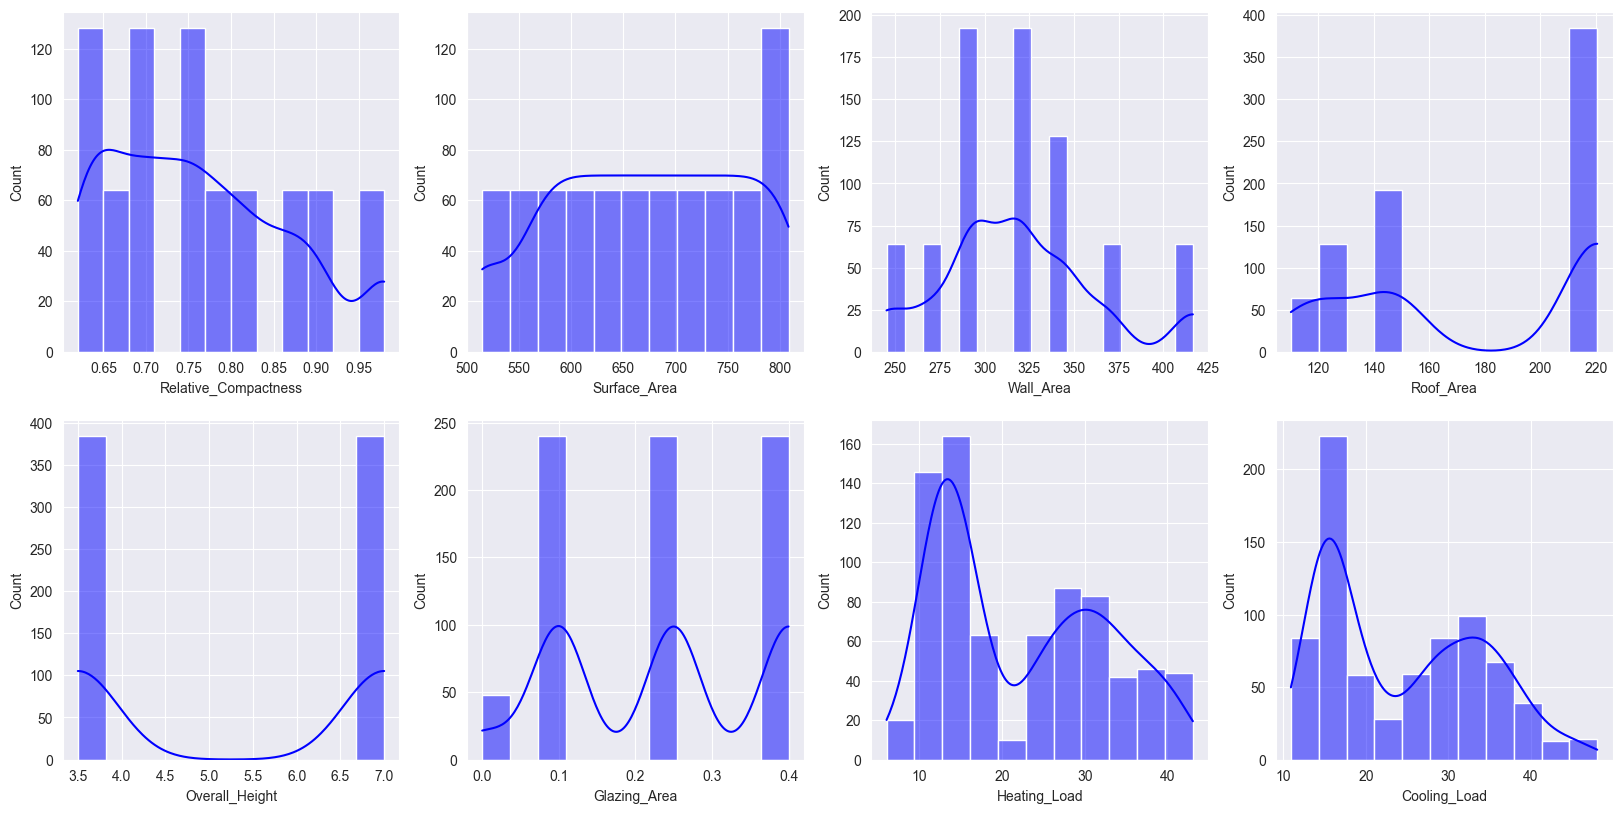

In [114]:
# Histogram plots
subp.histogram()

Conclusions:

- There is no normally distributed variable.

- Cooling Load and Heating Load have similiart distributions.

- There are just two values for Overall Height.

#### 2.1.2) Boxplots

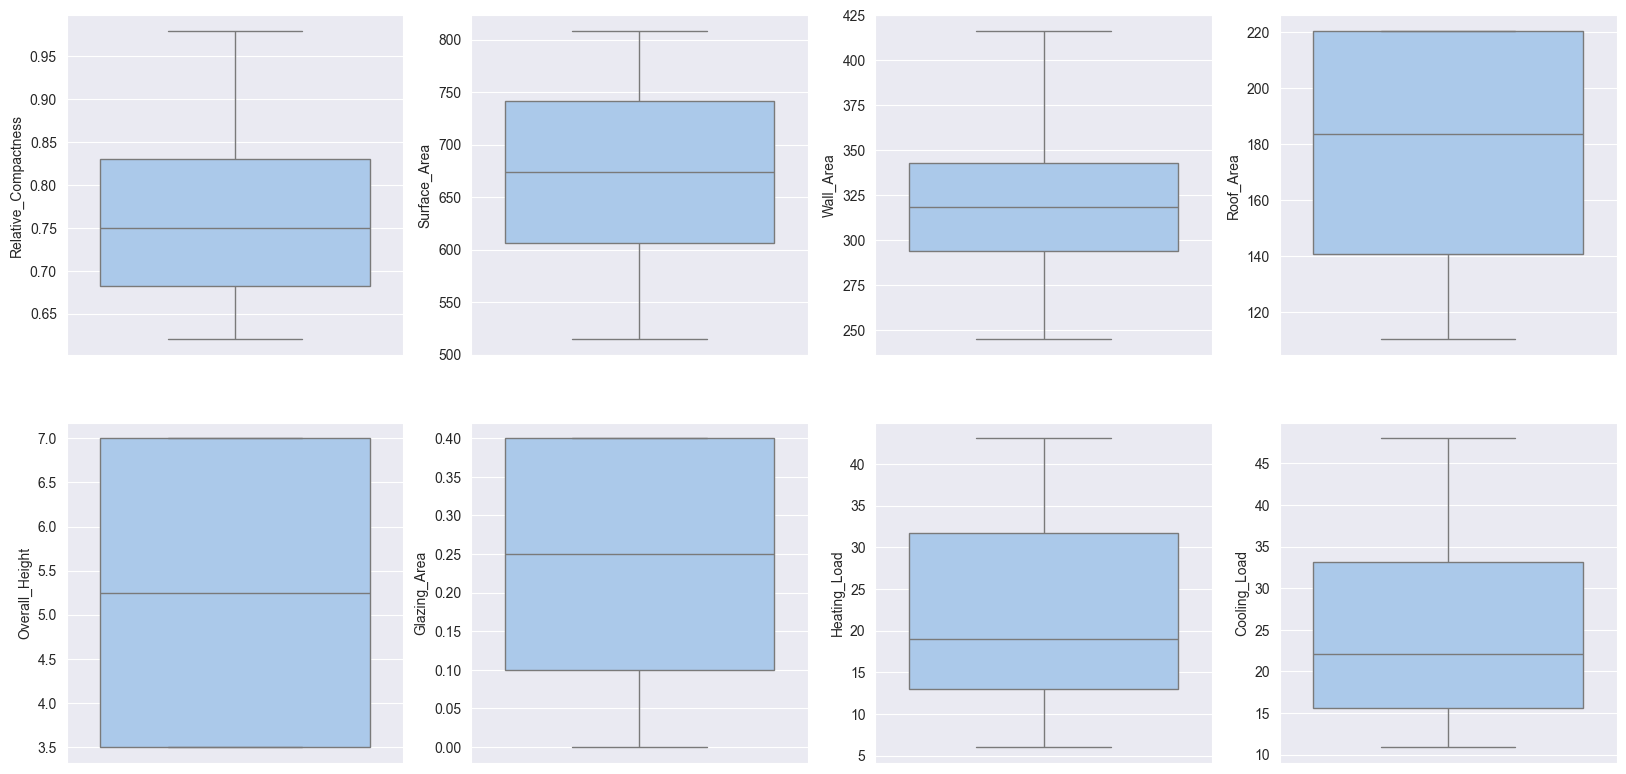

In [115]:
# Boxplots
subp.boxplot()

Conclusions:

- No outliers were detected using boxplot.

### 2.2) Correlations

Since the variables are not Normally distributed, it is not indicated to use Pearson's correlations. So we will use Spearman correlations, a type of non-parametric mesure of rank correlation (a statistical dependence between rankings of two variables). So it assesses how good the relation between two variables can be described using a monotonic function. Furthermore, it can generate numbers between -1 and 1, where -1 means a strong negative correlation and 1 means a strong positive correlation.

In [116]:
# Function to plot heatmap of correlations:

class Correlations_plot:
    def __init__(self, df) -> None:
        self.dataframe = df
    
    def pearson(self):
        correlations = self.dataframe.corr()
        mask =  np.zeros_like(correlations)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(27, 10))
        sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");
    
    def spearman(self):
        correlations = self.dataframe.corr(method="spearman")
        mask =  np.zeros_like(correlations)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(27, 10))
        plt.title("Spearman correlation")
        sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");
        


In [117]:
corr_plots = Correlations_plot(df)

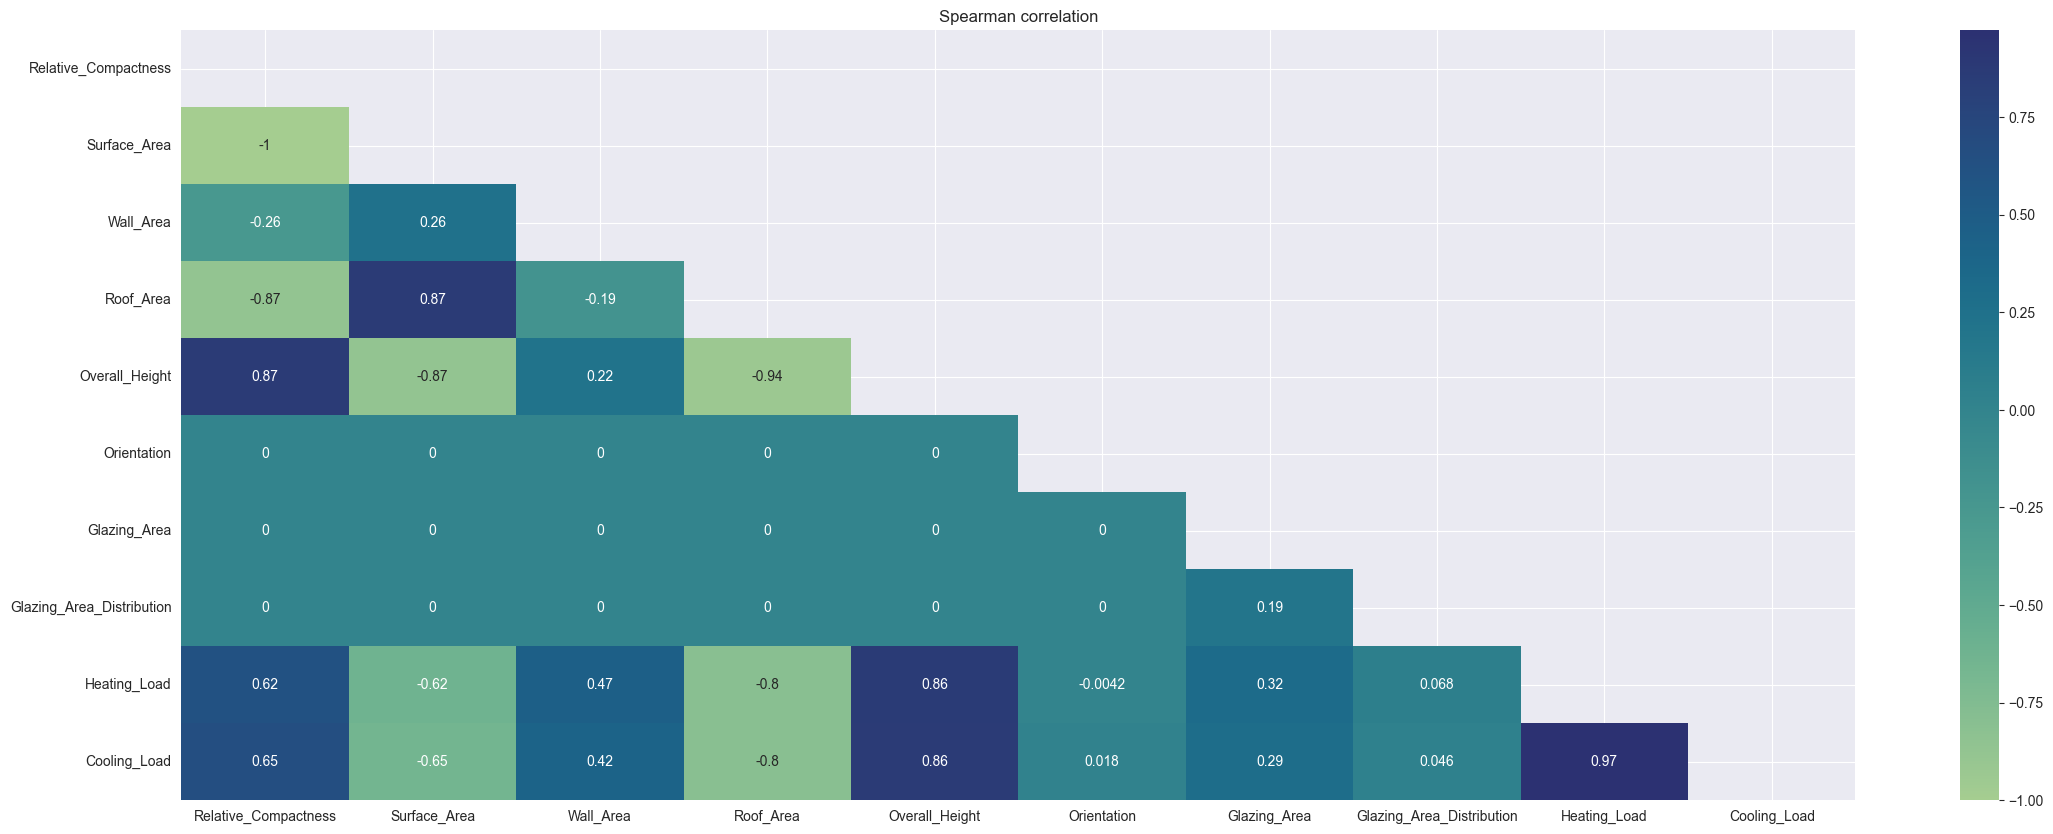

In [118]:
# Spearman's Correlation:
corr_plots.spearman()

In [119]:
# Chi-squared:
def ch2_func(features, target):
    cat_columns = features.columns
    statistics = []
    p_values = []
    
    for feature in cat_columns:
        # Creating a contingency table:
        df_contingency = pd.crosstab(features[feature], target)

        # Chi squared:
        statistic, p_value, dof, expected = chi2_contingency(df_contingency)
    
        statistics.append(statistic)
        p_values.append(p_value)
        
    dicionario = dict(Chi_Squared=statistics, P_value=p_values)
    df_ch = pd.DataFrame(index=cat_columns, data=dicionario)
    return df_ch

In [120]:
# Categorical Correlation with Heatig Load:
corr = ch2_func(df[cat_cols], df["Heating_Load"])
corr

,Chi_Squared,P_value
Orientation,1765.866667,0.422975
Glazing_Area_Distribution,3108.977778,0.009005


In [121]:
# Categorical Correlation with Cooling Load:
corr = ch2_func(df[cat_cols], df["Cooling_Load"])
corr

,Chi_Squared,P_value
Orientation,1928.000000,0.35126
Glazing_Area_Distribution,3277.333333,0.10045


Conclusions:
- There are some Multicollinearity between Overall Height and Roof Area, Relative Compactess and Surface Area. 
- Cooling Load and Heating Load are extremelly correlated with each other.
- Surface Area have a negative correlation with Cooling and Heating Load.
- The Glazing Area is the least correlated numerical variable with the Response variables.
- Overall Height is the most correlated variable with the Response variables.
- Regarding the categorical explanatory variables, Orientation does not seem to be correlated with any one of the Response variables.
- Given the chi squared test, Glazing Area Distribution is strongly correlated with Heating Load(Assuming p-value limit of 0.05), but not with Cooling Load.

### 2.3) Exploring relations between Variables

#### 2.3.1) Relative Compactness and Cooling/Heating loads 

Relative Compactness is a indicator of how compact is a enclosured shape, which means that more compact the building less will be the empty space inside that needs to be heated or cooled.

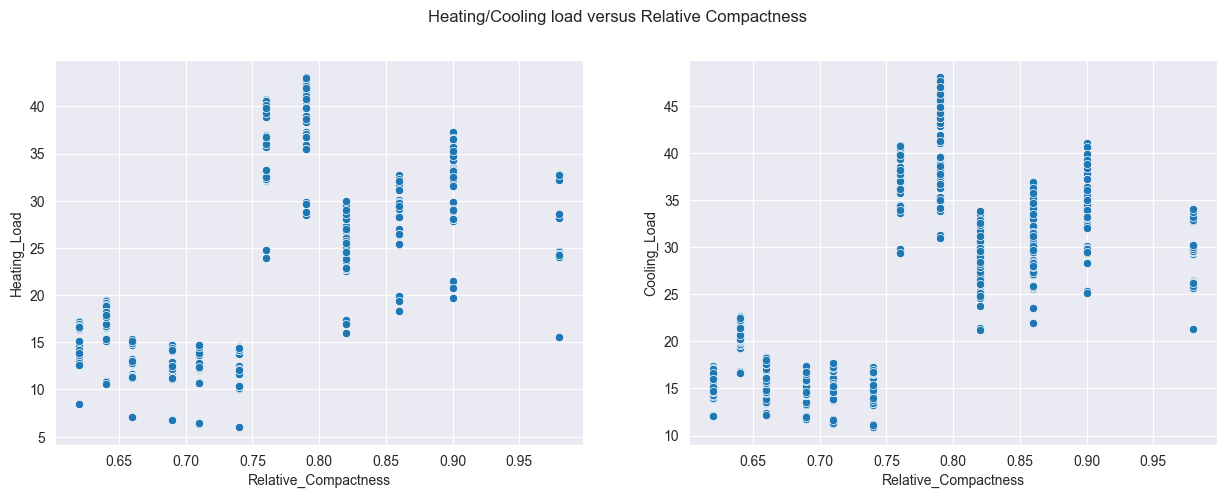

In [122]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Relative Compactness")
sns.scatterplot(x=df["Relative_Compactness"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Relative_Compactness"], y=df["Cooling_Load"], ax=ax[1]);

Conclusion:
- There are 12 different kinds of relative compactness.
- The relation with the reponse variables does not seem simple, but we can see that more compact the building tend to be more energy efficient.
- There are two different groups divided in 0.75

#### 2.3.2) Surface Area and Cooling/Heating loads 

Surface area of each shape.

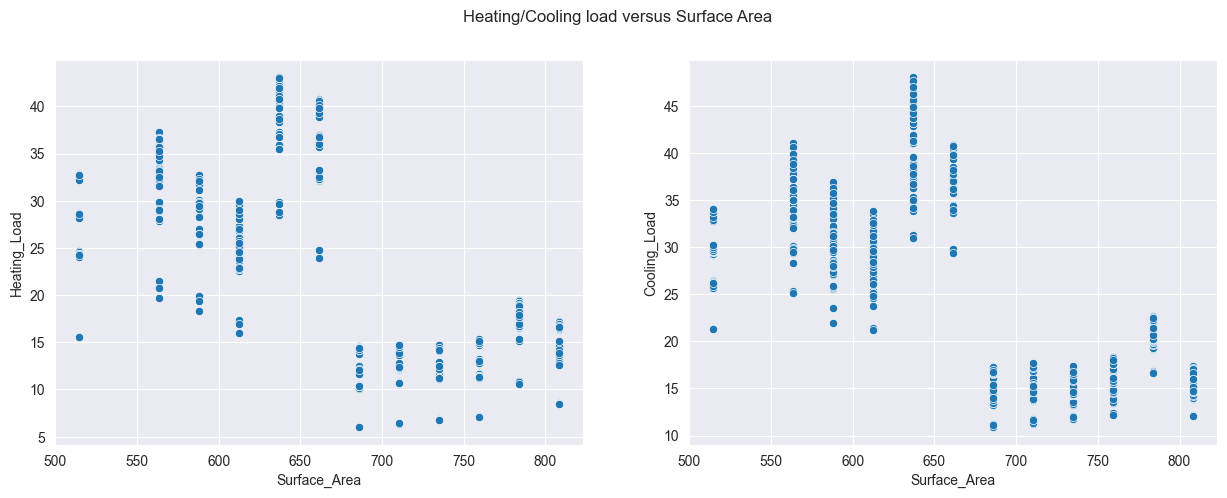

In [123]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Surface Area")
sns.scatterplot(x=df["Surface_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Surface_Area"], y=df["Cooling_Load"], ax=ax[1]);

Conclusions:
- It is divided in two groups, between 650 and 700 squared meters.
- It can be inferred that shapes with less surface area are much less energy efficient.

#### 2.3.3) Wall Area and Cooling/Heating loads 

Wall area is the area of the shape that is covered by the wall.

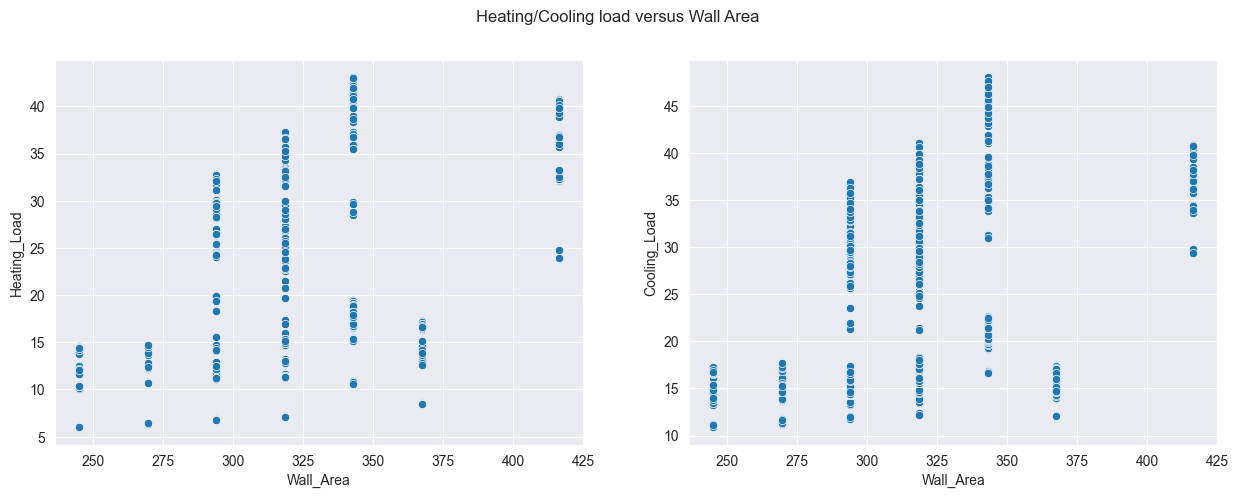

In [124]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Wall Area")
sns.scatterplot(x=df["Wall_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Wall_Area"], y=df["Cooling_Load"], ax=ax[1]);

Conclusions:
- The relation is clearly not linear.
- Shapes with wall area below 300 are more energy efficient.
- There are some buildings that have wall area between 350 and 375 and are as energy efficient as building with low wall area.

#### 2.3.4) Roof Area and Cooling/Heating loads 

Roof area is the area of composed of the roof.

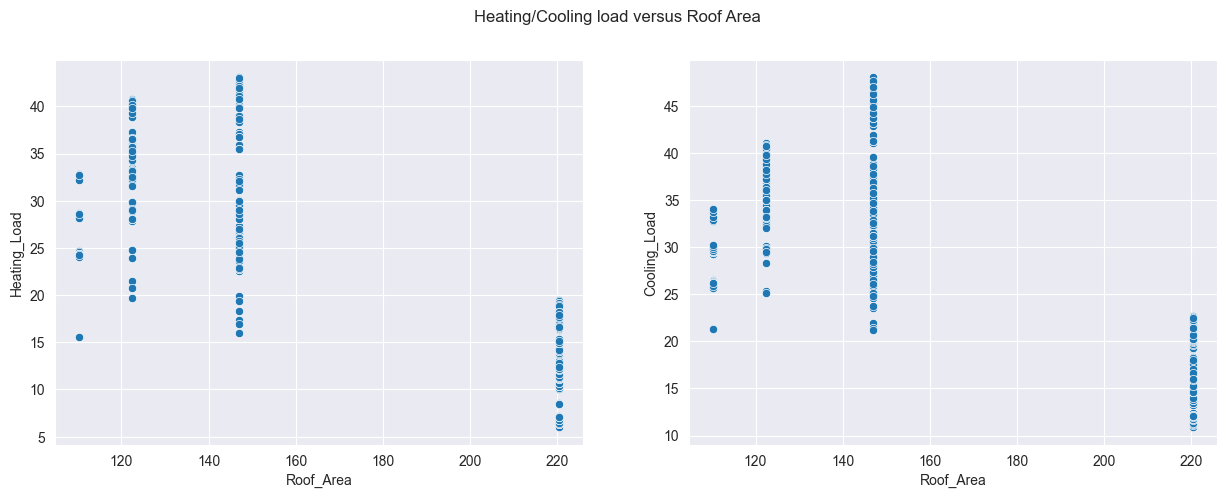

In [125]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Roof Area")
sns.scatterplot(x=df["Roof_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Roof_Area"], y=df["Cooling_Load"], ax=ax[1]);

Conclusions:
- There are just four different kinds of roof area.
- It could be infered that less roof area means more necessary energy to heat and cool.
- Majority of the buildings have roof area below 160.

#### 2.3.5) Overall Height and Cooling/Heating loads 

Overall Height is the general height of the building.

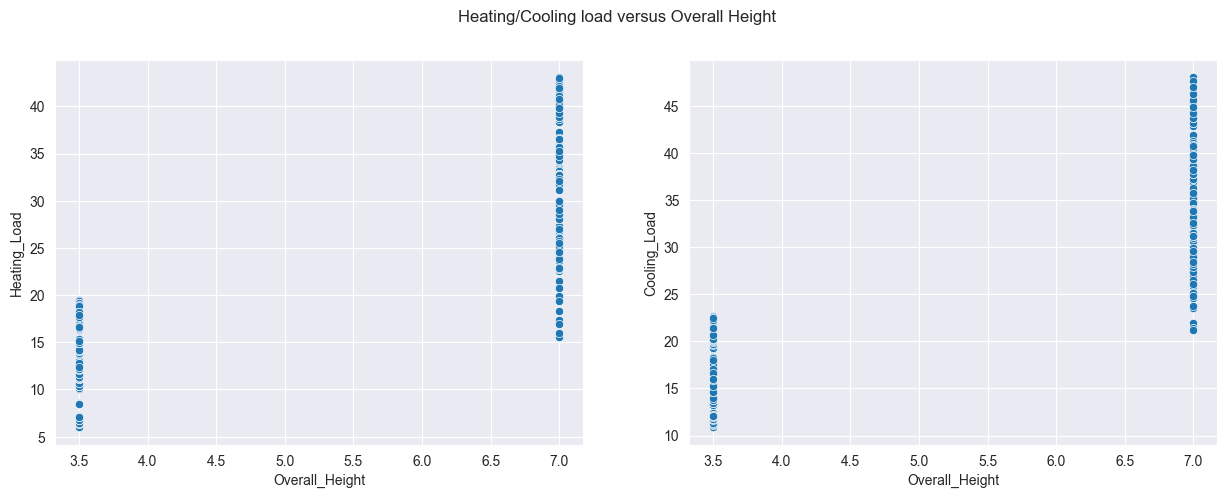

In [126]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Overall Height")
sns.scatterplot(x=df["Overall_Height"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Overall_Height"], y=df["Cooling_Load"], ax=ax[1]);

Conclusions:
- There are just two types of Heights, 3.5 and 7.0
- The majority of the buildings have Overall Height of 7.0 and they are less energy efficient.
- Standard Deviantion of building with hight Overall Height is greater than those with Overall Height of 3.5

#### 2.3.6) Orientation and Cooling/Heating loads

Orientation of the building rotated 90° and with the face toward North, South, West or East.

In [127]:
def map_orientation(row):
    if row == 2:
        return "North"
    elif row == 3:
        return "East"
    elif row == 4:
        return "South"
    else:
        return "West"

In [128]:
data_orientation_mapped = df["Orientation"].apply(map_orientation)
new_dataframe = df[["Heating_Load", "Cooling_Load"]].copy()
new_dataframe["Orientation_mapped"] = data_orientation_mapped
grouped = new_dataframe.groupby("Orientation_mapped", observed=False).mean().reset_index()

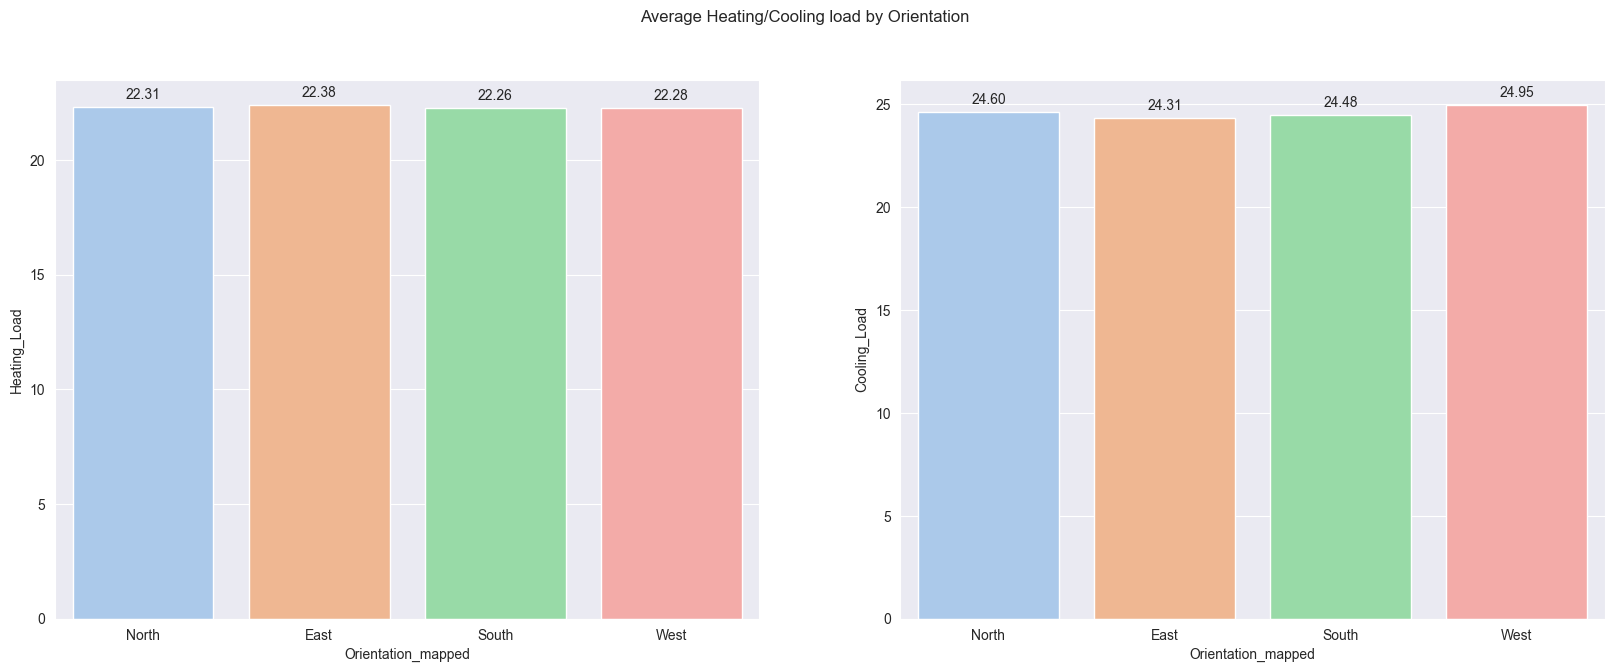

In [129]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(20, 7))
fig.suptitle("Average Heating/Cooling load by Orientation")
sns.barplot(x=grouped["Orientation_mapped"], y=grouped["Heating_Load"], ax=ax[0], 
            hue=grouped["Orientation_mapped"], legend=False, palette="pastel")

sns.barplot(x=grouped["Orientation_mapped"], y=grouped["Cooling_Load"], ax=ax[1], 
            hue=grouped["Orientation_mapped"], legend=False, palette="pastel");

for eixo in ax:
    for p in eixo.patches:
        eixo.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points'
                      )
plt.show()

Conclusions:
- The average energy is very similar for all types of orientation.
- It can be inferred that the East orientation has the highest average energy required to heat the building.
- It also can be inferred that the West orientatio has the average energy required to cool the building

#### 2.3.7) Glazing Area and Cooling/Heating loads

Glazing area is the percentage of floor area.

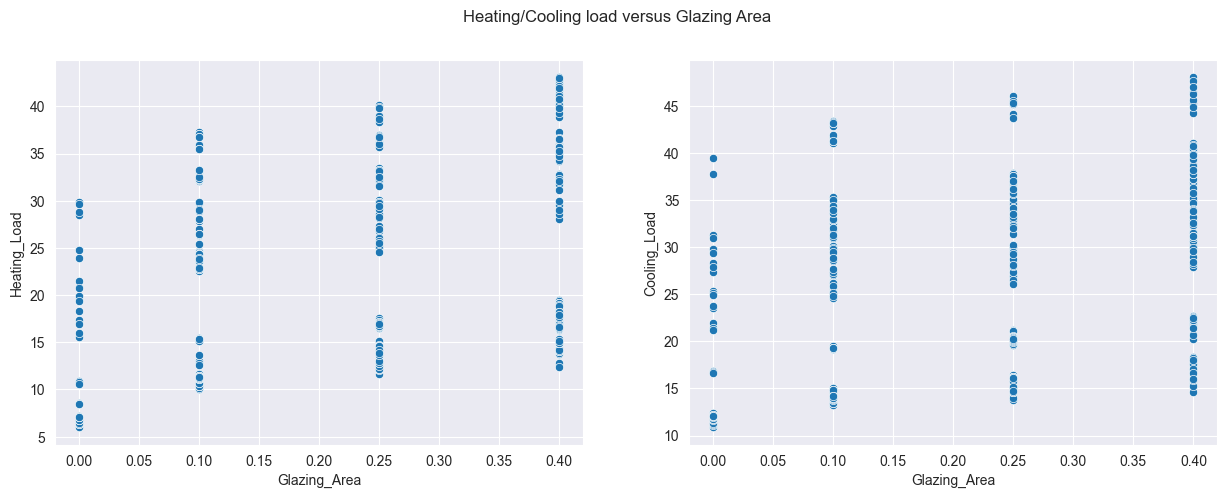

In [130]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Heating/Cooling load versus Glazing Area")
sns.scatterplot(x=df["Glazing_Area"], y=df["Heating_Load"], ax=ax[0])
sns.scatterplot(x=df["Glazing_Area"], y=df["Cooling_Load"], ax=ax[1]);

Conclusions:
- There are just four kinds of Glazing area (0, 0.1, 0.25, 0.4)
- It can be inferred that less glazing area means buildings more energy efficient.

#### 2.3.8) Glazing Area Distribution and Cooling/Heating loads

Glazing area distribution is the percentage of the glazing area distributed based on five different approachs:
- Uniform (1): With 25% glazing on each side of the building.
- North (2): With 55% of the glazing area on north side and 15% on each other sides.
- East (3): With 55% of the glazing area on east side and 15% on each other sides.
- South (4): With 55% of the glazing area on south side and 15% on each other sides.
- West (5): With 55% of the glazing area on west side and 15% on each other sides.
- No glazing area. (0)


In [131]:
df["Glazing_Area_Distribution"].value_counts()

Glazing_Area_Distribution
1    144
2    144
3    144
4    144
5    144
0     48
Name: count, dtype: int64

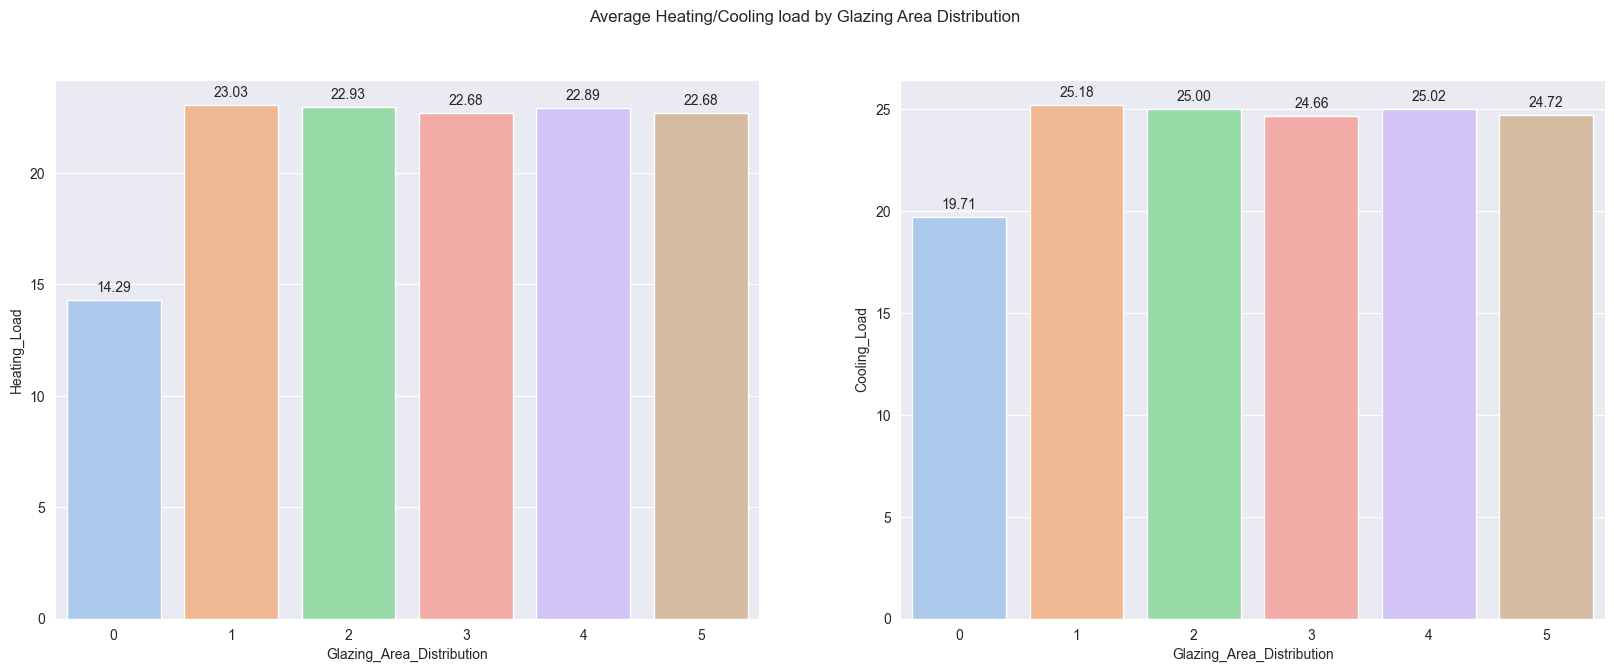

In [132]:
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(20, 7))
fig.suptitle("Average Heating/Cooling load by Glazing Area Distribution")
df_grouped_glazing_area_dist = df.groupby("Glazing_Area_Distribution", observed=False)[["Heating_Load", "Cooling_Load"]].mean().reset_index()
sns.barplot(x=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], y=df_grouped_glazing_area_dist["Heating_Load"], ax=ax[0], 
            hue=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], legend=False, palette="pastel")

sns.barplot(x=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], y=df_grouped_glazing_area_dist["Cooling_Load"], ax=ax[1],
            hue=df_grouped_glazing_area_dist["Glazing_Area_Distribution"], legend=False, palette="pastel");

for eixo in ax:
    for p in eixo.patches:
        eixo.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points'
                      )
plt.show()

Conclusions:
- Buildings with no glazing area are the most energy efficient.
- It is less costly to heat the building than to cool it.
- The glazing distribution associated with the highest average energy consumption for both reponse variables is the Uniform.

## 3) Preprocessing

In [133]:
seed = 42
features = df.drop(columns=["Heating_Load", "Cooling_Load"])
targets = df[["Heating_Load", "Cooling_Load"]]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, shuffle=True, random_state=seed)

### 3.1) Categorical Transformation

In [135]:
one_hot = OneHotEncoder(sparse_output=False, drop="first", dtype=np.int8)
cat_train_transf = one_hot.fit_transform(X_train[cat_cols])
cat_test_transf = one_hot.transform(X_test[cat_cols])

In [136]:
X_train.drop(columns=cat_cols, inplace=True)
X_test.drop(columns=cat_cols, inplace=True)
X_train[one_hot.get_feature_names_out()] = cat_train_transf
X_test[one_hot.get_feature_names_out()] = cat_test_transf

In [137]:
X_train.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Glazing_Area,Orientation_3,Orientation_4,Orientation_5,Glazing_Area_Distribution_1,Glazing_Area_Distribution_2,Glazing_Area_Distribution_3,Glazing_Area_Distribution_4,Glazing_Area_Distribution_5
334,0.62,808.5,367.5,220.5,3.5,0.25,0,1,0,1,0,0,0,0
139,0.64,784.0,343.0,220.5,3.5,0.10,0,0,1,0,1,0,0,0
485,0.90,563.5,318.5,122.5,7.0,0.25,1,0,0,0,0,0,0,1
547,0.79,637.0,343.0,147.0,7.0,0.40,0,0,1,1,0,0,0,0
18,0.79,637.0,343.0,147.0,7.0,0.00,0,1,0,0,0,0,0,0


### 3.2) Feature Selection

In [34]:
# Class that put together many feature selection techniques:

class feature_selector:
    seed = 42
    def __init__(self, X, y) -> None:
        self.X_train = X
        self.y_train = y
    
    def  randomforestR_imp(self) -> None:
        model = RandomForestRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting RandomForest Regression Importance:
        plt.title("RandomForest Importance - " + self.y_train.name)
        plt.xlabel("Importance")
        fig = sns.barplot(x=series.values, y=series.index, hue=series.index, palette="pastel", legend=False)
        fig.set_ylabel('')
        

    def xgbR_imp(self) -> None:
        model = XGBRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=model.feature_names_in_, data=model.feature_importances_).sort_values(ascending=False)

        # Plotting XGboost Regression Feature Importance:
        plt.title("XGBoost Feature Importance - " + self.y_train.name)
        plt.xlabel("Importance")
        fig = sns.barplot(y=series.index, x=series.values, hue=series.index, palette="pastel", legend=False)
        fig.set_ylabel('')

    # Univariate feature selection:
    def univariate(self, statistic, n="all") -> None:
        selector = SelectKBest(score_func=statistic, k=n)
        selector.fit(self.X_train, self.y_train)
        
        series = pd.Series(index=selector.feature_names_in_, data=selector.scores_).\
            sort_values(ascending=False)
        plt.title("F-Regression Filtering - " + self.y_train.name)
        plt.xlabel("F-score")
        fig = sns.barplot(y=series.index, x=series.values, hue=series.index, palette="pastel", legend=False)
        fig.set_ylabel('')

        return selector, fig
    
    # Wrapper method for feature selection:
    def refcv(self):
        
        models = {
            "Lasso":Lasso(random_state=feature_selector.seed),
            "Ridge":Ridge(random_state=feature_selector.seed),
            "RandomForestR":RandomForestRegressor(random_state=feature_selector.seed),
            "ExtraTreeR":ExtraTreesRegressor(random_state=feature_selector.seed),
            "XGB":XGBRegressor(random_state=feature_selector.seed)
        }

        splits=10
        cross = KFold(n_splits=splits, random_state=feature_selector.seed, shuffle=True)
        ind = [f"Columns {i}" for i in range(1, len(self.X_train.columns) + 1)]
        df = pd.DataFrame(index=ind)
        
        minimo = np.inf
        name = ""
        for key, model in models.items():
            rfecv = RFECV(estimator=model, step=1, cv=cross, min_features_to_select=1, scoring="neg_mean_squared_error")
            rfecv.fit(self.X_train, self.y_train)
            root_mean = np.sqrt(-rfecv.cv_results_["mean_test_score"])
            df[key] = root_mean
            best_value = root_mean[np.argmin(root_mean)]

            if minimo > best_value:
                minimo = best_value
                best_features = rfecv.support_
                name = key

        df_features = pd.DataFrame(columns=self.X_train.columns, data=best_features.reshape(1, -1), index=[name])
    
        return df,  df_features.transpose()

#### 3.2.1) Filtering Selection

Filtering selection is a statistical feature selection technique that is based on the correlation score or dependence between the input variable and the target variable. So, after calculate this correlation or dependence based on a statistical approach, the variables can be filtered to choose the most relevant features. Since this problem have categorical and numerical data, the method below it is not appropriate, since the f-regression assume numerical features and numerical target. However, it will be used anyway, to see what is going to generate. 

In [105]:
f_selector_heat = feature_selector(X_train, y_train["Heating_Load"])
f_selector_cool = feature_selector(X_train, y_train["Cooling_Load"])

Heating Load:

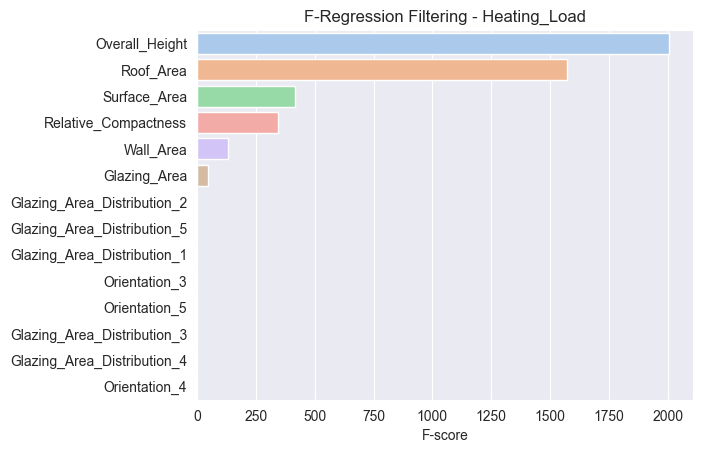

In [106]:
_, ax_heat = f_selector_heat.univariate(statistic=f_regression)

Cooling load:

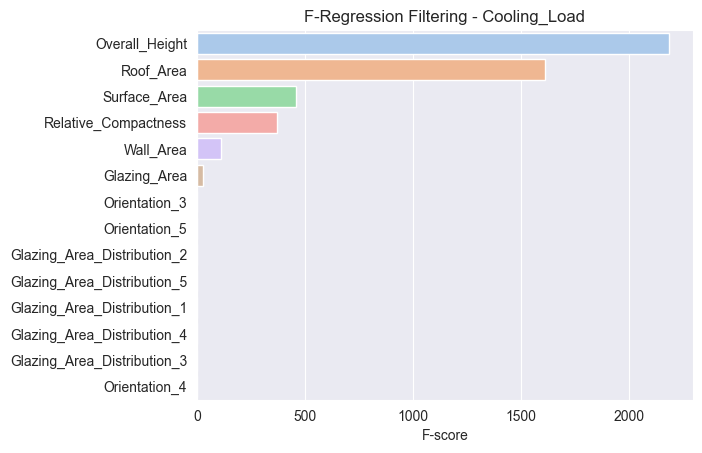

In [107]:
_, ax_cool = f_selector_cool.univariate(statistic=f_regression)

Conclusions:
- The F-regression approach shows that the only important features for modeling Cooling and Heating Load are, Overall Height, Roof Area, Surface Area, Surface Compactness, Wall Area and Glazing Area. (The numerical ones)

#### 3.2.2) Random Forest Importance

Heating Load:

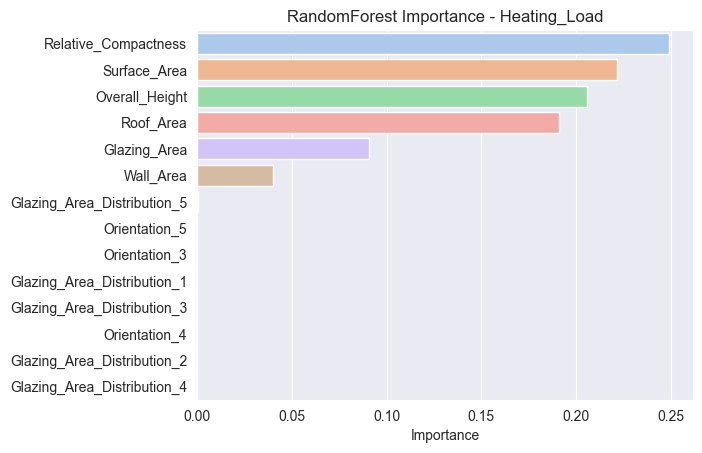

In [108]:
f_selector_heat.randomforestR_imp()

Cooling Load

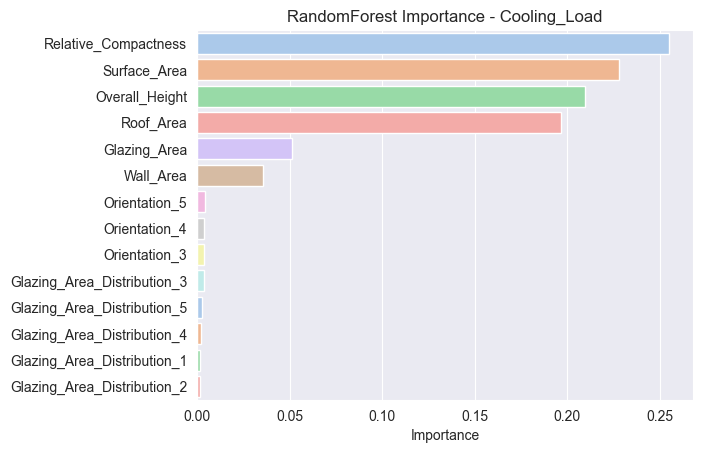

In [109]:
f_selector_cool.randomforestR_imp()

Conclusions:
- The Random Forest importance shows that Relative Compactness is the most important feature and for modelling Cooling and Heating Load.
- The categorical Features are less important based on this approach.

#### 3.2.3) XGBoost Importance

Heating Load

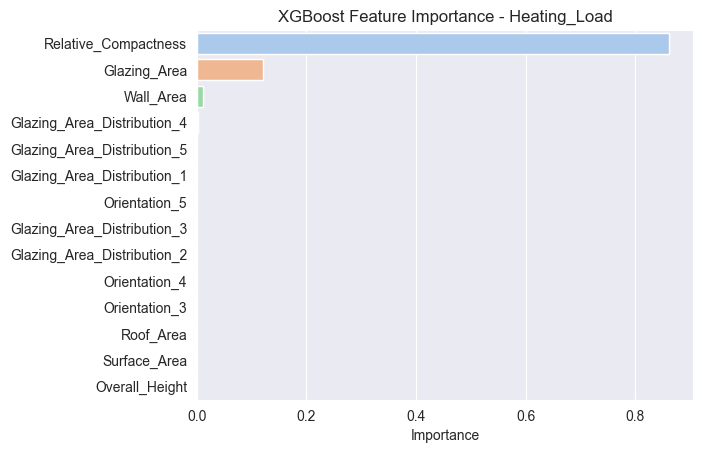

In [110]:
f_selector_heat.xgbR_imp()

Cooling Load

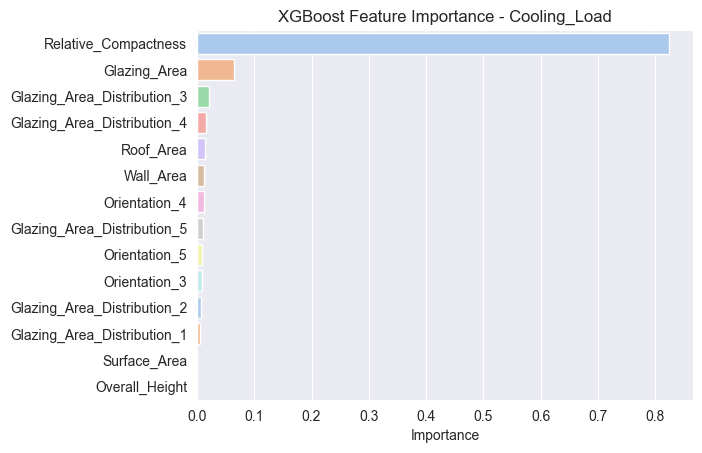

In [111]:
f_selector_cool.xgbR_imp()

Conclusions:
- The Xgboost importance selects, basically, three of the fourteen features.
- Relative Compactness is the most important feature for modelling Cooling and Heating Load.

#### 3.2.4) Recursive Feature Elimination (RFE)

Recursive Feature Elimination (REF) is a feature selection technique that first fits an arbitrary estimator with all the features, and then uses an importance or coefficient attribute to identify the least important variable. It then drops this variable and fits another model without it until it reaches the minimal number of features.

Heating Load:

In [112]:
df_results, df_features = f_selector_heat.refcv()

In [113]:
display(df_results)
display(df_features)

,Lasso,Ridge,RandomForestR,ExtraTreeR,XGB
Columns 1,9.049256,7.944896,3.168256,4.649530,3.166720
Columns 2,4.654702,7.447839,3.168256,4.408233,0.487845
Columns 3,4.654702,3.229058,3.168256,3.166719,0.487805
Columns 4,4.654702,3.255531,3.168256,0.487696,0.488669
Columns 5,4.654702,3.276499,0.511380,0.487695,0.492795
Columns 6,4.654702,3.264698,0.511874,0.487701,0.496219
Columns 7,4.654702,3.205819,0.526240,0.491274,0.507068
Columns 8,4.654702,3.113832,0.525180,0.510244,0.495124
Columns 9,4.654702,3.092927,0.537841,0.514879,0.491984
Columns 10,4.654702,3.093520,0.542342,0.536256,0.467112


,XGB
Relative_Compactness,True
Surface_Area,False
Wall_Area,True
Roof_Area,True
Overall_Height,False
Glazing_Area,True
Orientation_3,True
Orientation_4,True
Orientation_5,True
Glazing_Area_Distribution_1,True


Cooling Load

In [114]:
df_results, df_features = f_selector_cool.refcv()

In [115]:
display(df_results)
display(df_features)

,Lasso,Ridge,RandomForestR,ExtraTreeR,XGB
Columns 1,8.344955,7.369181,2.702331,4.234779,2.697678
Columns 2,4.473626,7.103461,2.702331,4.008131,1.718501
Columns 3,4.464892,3.374807,2.702331,2.697678,1.802838
Columns 4,4.464894,3.401609,2.702331,2.697678,1.869002
Columns 5,4.464894,3.404670,1.720901,1.718463,1.963378
Columns 6,4.464894,3.397339,1.721829,1.718457,1.912751
Columns 7,4.464894,3.408552,1.796088,1.853419,1.824659
Columns 8,4.464894,3.383908,1.802905,2.047016,1.685694
Columns 9,4.464894,3.369163,1.885025,2.072569,1.444472
Columns 10,4.464894,3.363168,1.912022,2.203391,1.329572


,XGB
Relative_Compactness,True
Surface_Area,False
Wall_Area,True
Roof_Area,True
Overall_Height,False
Glazing_Area,True
Orientation_3,True
Orientation_4,True
Orientation_5,True
Glazing_Area_Distribution_1,False


Concusions:

- The Recursive Feature Elimination has chosen twelve features that best describe the Heating Load. Furthermore, the features eliminated are Surface Area and Overall Height.

- The Recursive Feature Elimination has chosen eleven features that best describe the Cooling Load. Furthermore, the features eliminated are Surface Area, Overall Height and Glazing Area Distribtion 1.

We will use the Recurssive Feature Elimination indication to select the features for Heating Load and Cooling Load separately.

In [138]:
# Let's select the features according to RFE:
drop_columns = ["Overall_Height", "Surface_Area"]

### 3.3) Numerical Transformation

#### 3.3.1) MinMax Scaler

Definition:
- MinMax Scaler is also called as Normalization, which is a technique that rescale all the values, usually, within a range of 0 and 1.

Mathematical Definition:

$X_{new_{i}} = \frac{X_{i} - X_{min_{i}}}{X_{max_{i}} - X_{min_{i}}}$


In [139]:
min_max = MinMaxScaler()
X_train_min_max = X_train.copy()
X_test_min_max = X_test.copy()
num_cols_features = [i for i in num_cols if i not in ["Heating_Load", "Cooling_Load"] + drop_columns]

X_train_min_max[num_cols_features] = min_max.fit_transform(X_train[num_cols_features])
X_test_min_max[num_cols_features] = min_max.transform(X_test[num_cols_features])

In [140]:
X_train_min_max_heat = X_train_min_max.drop(columns=drop_columns)
X_train_min_max_cool = X_train_min_max.drop(columns=drop_columns + ["Glazing_Area_Distribution_1"])

X_test_min_max_heat = X_test_min_max.drop(columns=drop_columns)
X_test_min_max_cool = X_test_min_max.drop(columns=drop_columns + ["Glazing_Area_Distribution_1"])

#### 3.3.2) Standard Scaler

Definition:
- The Standard Scaler is a technique that rescales the distribution of a variable so that the mean of the observed sample is 0 and the standard deviation is 1. It is particularly useful for algorithms that rely on distance measures, such as K-means and K-nearest neighbors (KNN). Additionally, it is a recommended choice for algorithms based on neural networks.

OBS: Standard Scaler can perform slightly worst than the other transformations because it assumes that the data is normally distributed. However you can still standardize your data.

Matematical Definition:

$X_{new_{i}} = \frac{X_{i} - \hat{\mu}_{i}}{\sigma_{i}}$

- $\mu:$ Mean of the sample.
- $\sigma:$ Standard Deviation of the sample.

In [145]:
std_scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[num_cols_features] = std_scaler.fit_transform(X_train[num_cols_features])
X_test_std[num_cols_features] = std_scaler.transform(X_test[num_cols_features])

In [146]:
X_train_std_heat = X_train_std.drop(columns=drop_columns)
X_train_std_cool = X_train_std.drop(columns=drop_columns + ["Glazing_Area_Distribution_1"])

X_test_std_heat = X_test_std.drop(columns=drop_columns)
X_test_std_cool = X_test_std.drop(columns=drop_columns + ["Glazing_Area_Distribution_1"])

### 3.4) Selection the best Algorithm and Transformation

In [148]:
# Function used to evaluate the best algorithms:
def melhor_modelo(X_train, y_train):

    seed = 42
    cv = 5
    score = ['neg_root_mean_squared_error', 'r2']
    result_rmse = {}
    result_r2 = {}

    dicionario = { 
                "Lasso":Lasso(random_state=seed),
                "Ridge":Ridge(random_state=seed),
                "SVR":SVR(),
                "RandomForestR":RandomForestRegressor(random_state=seed),
                "ExtraTreeR":ExtraTreesRegressor(random_state=seed),
                "XGB":XGBRegressor(random_state=seed),
                "MLP":MLPRegressor(random_state=seed, max_iter=2000)
                 }


    for name, model in dicionario.items():
        k_fold = KFold(n_splits=cv, random_state=seed, shuffle=True)
        result = cross_validate(model, X_train, y_train, cv=k_fold, scoring=score)

        result_rmse[name] = -result['test_neg_root_mean_squared_error']
        result_r2[name] = result['test_r2']
        
        
    result_pd_rmse = pd.DataFrame(data=result_rmse)
    result_pd_r2 = pd.DataFrame(data=result_r2)
    
    return result_pd_rmse, result_pd_r2

#### 3.4.1) Using Min Max Scaler

Heating Load:

In [149]:
result_rmse, result_r2 = melhor_modelo(X_train_min_max_heat, y_train["Heating_Load"])

In [150]:
result_rmse.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,5.635425,3.511645,4.214314,0.567554,0.600772,0.444724,2.610852
std,0.525109,0.282267,0.443683,0.064476,0.066688,0.039268,0.133966
min,4.787174,3.186465,3.508167,0.503571,0.514737,0.394055,2.403682
25%,5.460048,3.252193,4.055741,0.528608,0.574652,0.414195,2.599403
50%,5.941979,3.592084,4.435570,0.541726,0.580083,0.457448,2.605690
75%,5.965690,3.686070,4.474192,0.599818,0.652140,0.469953,2.679893
max,6.022232,3.841411,4.597901,0.664044,0.682247,0.487969,2.765591


In [151]:
result_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.686483,0.877534,0.824659,0.996690,0.996329,0.998005,0.931442
std,0.029093,0.015839,0.020575,0.001229,0.001114,0.000496,0.014889
min,0.658537,0.861846,0.802075,0.994586,0.994779,0.997288,0.906097
25%,0.666802,0.870146,0.813553,0.996649,0.995586,0.997782,0.932762
50%,0.671157,0.873453,0.814763,0.997237,0.996866,0.998041,0.936074
75%,0.717277,0.878515,0.844006,0.997350,0.996908,0.998373,0.937068
max,0.718640,0.903709,0.848900,0.997626,0.997505,0.998538,0.945207


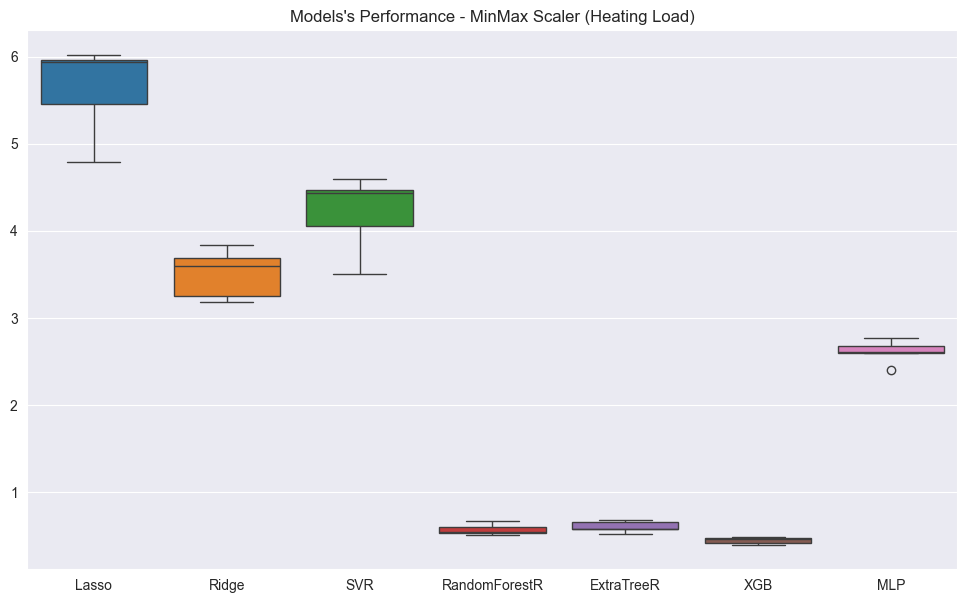

In [152]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - MinMax Scaler (Heating Load)")
sns.boxplot(result_rmse);

Cooling Load:

In [153]:
result_rmse, result_r2 = melhor_modelo(X_train_min_max_cool, y_train["Cooling_Load"])

In [154]:
result_rmse.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,5.319421,3.851700,4.193462,1.833614,2.171504,1.322625,3.010863
std,0.657862,0.440278,0.567720,0.074014,0.173490,0.161777,0.172151
min,4.177826,3.170578,3.183387,1.734782,1.927063,1.099027,2.829677
25%,5.389355,3.688803,4.359966,1.808527,2.054478,1.243731,2.855561
50%,5.513893,4.003119,4.425546,1.815253,2.244550,1.353929,2.997155
75%,5.742977,4.092779,4.484568,1.881778,2.312608,1.385019,3.179271
max,5.773053,4.303220,4.513840,1.927732,2.318819,1.531417,3.192652


In [155]:
result_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.685651,0.834863,0.804677,0.962397,0.947401,0.980467,0.897932
std,0.042420,0.022267,0.029913,0.002950,0.004886,0.003396,0.016566
min,0.653129,0.808422,0.788699,0.957835,0.943753,0.975335,0.874141
25%,0.655197,0.823831,0.789209,0.961554,0.944372,0.979845,0.892906
50%,0.669642,0.825873,0.793445,0.962758,0.945257,0.980081,0.895428
75%,0.694835,0.857034,0.794019,0.964460,0.947970,0.983077,0.911396
max,0.755451,0.859155,0.858014,0.965379,0.955653,0.983997,0.915789


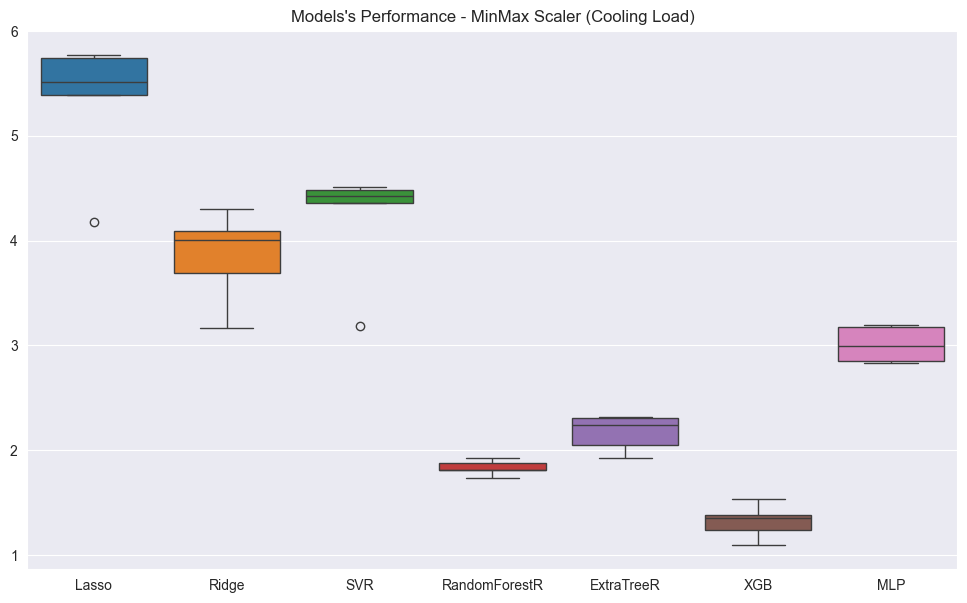

In [156]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - MinMax Scaler (Cooling Load)")
sns.boxplot(result_rmse);

#### 3.4.2) Using Standard Scaler

Heating Load:

In [157]:
result_rmse_std, result_r2_std = melhor_modelo(X_train_std_heat, y_train["Heating_Load"])

In [158]:
result_rmse_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,4.037634,3.170325,2.949319,0.567762,0.600772,0.444724,1.956147
std,0.396170,0.223196,0.198065,0.064051,0.066688,0.039268,0.621601
min,3.567380,2.841224,2.658146,0.504790,0.514737,0.394055,0.934044
25%,3.648409,3.054447,2.848246,0.528622,0.574652,0.414195,2.006816
50%,4.277515,3.236192,3.002531,0.542173,0.580083,0.457448,2.065843
75%,4.294177,3.334106,3.090385,0.599180,0.652140,0.469953,2.147266
max,4.400690,3.385657,3.147285,0.664046,0.682247,0.487969,2.626764


In [159]:
result_r2_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.838110,0.899876,0.913354,0.996688,0.996329,0.998005,0.957124
std,0.023913,0.014512,0.012334,0.001226,0.001114,0.000496,0.027327
min,0.818689,0.885457,0.900400,0.994586,0.994779,0.997288,0.915288
25%,0.826384,0.892683,0.907263,0.996656,0.995586,0.997782,0.956833
50%,0.829585,0.895338,0.910080,0.997232,0.996866,0.998041,0.959819
75%,0.836578,0.902457,0.916035,0.997350,0.996908,0.998373,0.961807
max,0.879311,0.923444,0.932992,0.997614,0.997505,0.998538,0.991874


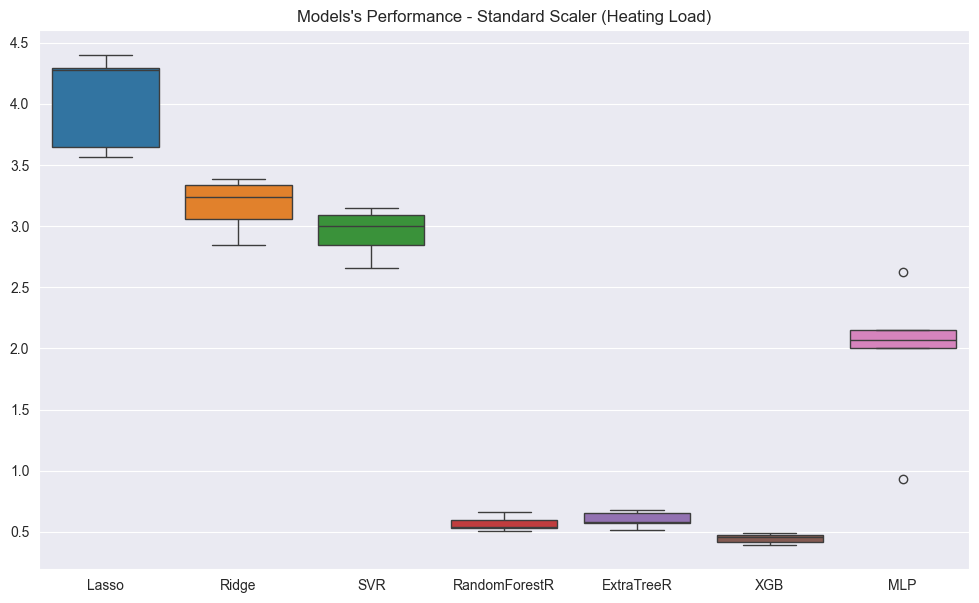

In [160]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - Standard Scaler (Heating Load)")
sns.boxplot(result_rmse_std);

Cooling Load:

In [161]:
result_rmse_std, result_r2_std = melhor_modelo(X_train_std_cool, y_train["Cooling_Load"])

In [162]:
result_rmse_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,4.277792,3.526455,3.266118,1.829386,2.171504,1.322625,2.248637
std,0.546627,0.337779,0.347704,0.068812,0.173490,0.161777,0.236672
min,3.394267,2.995531,2.691464,1.737913,1.927063,1.099027,1.869071
25%,4.157887,3.420702,3.282483,1.812802,2.054478,1.243731,2.246278
50%,4.412327,3.628474,3.324751,1.815424,2.244550,1.353929,2.287161
75%,4.664178,3.723150,3.404522,1.853934,2.312608,1.385019,2.321515
max,4.760303,3.864415,3.627372,1.926855,2.318819,1.531417,2.519162


In [163]:
result_r2_std.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.796433,0.861550,0.881453,0.962558,0.947401,0.980467,0.941735
std,0.031266,0.014215,0.012427,0.003054,0.004886,0.003396,0.019002
min,0.765562,0.845500,0.863873,0.957682,0.943753,0.975335,0.911085
25%,0.771207,0.849378,0.878221,0.961589,0.944372,0.979845,0.943159
50%,0.788454,0.861535,0.882923,0.963852,0.945257,0.980081,0.943376
75%,0.818362,0.874278,0.883745,0.964292,0.947970,0.983077,0.947798
max,0.838580,0.877060,0.898506,0.965373,0.955653,0.983997,0.963260


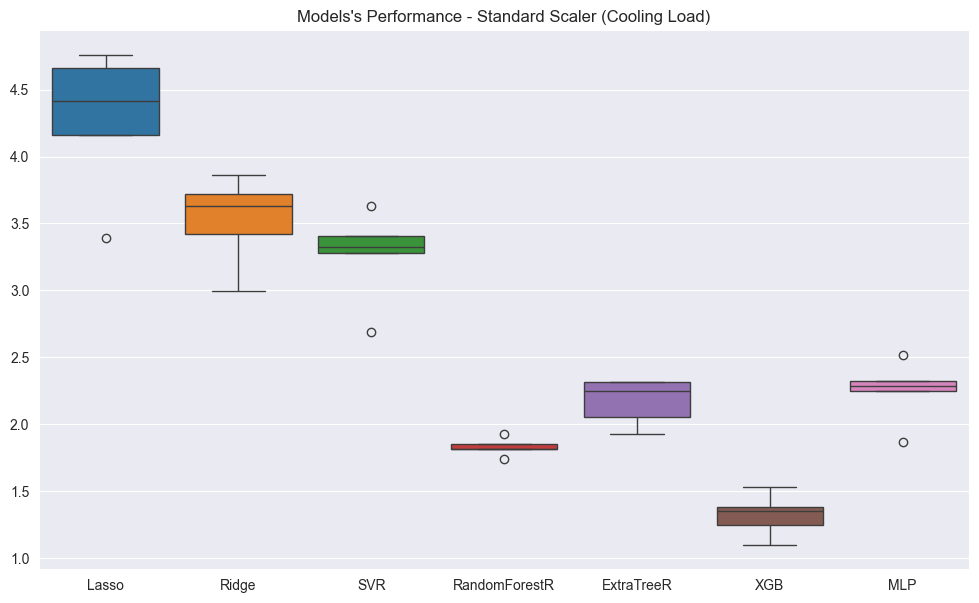

In [164]:
# Plotting model's performance:

plt.figure(figsize=(12, 7))
plt.title("Models's Performance - Standard Scaler (Cooling Load)")
sns.boxplot(result_rmse_std);

## 4) Fine Tuning

In [183]:
# Function for fine tuning an arbitrary model:

def tuning(X_train, y_train, modelo, params):
    
    cv = 5
    score = "neg_root_mean_squared_error"
    grid  = GridSearchCV(modelo, cv=cv, param_grid=params, 
                         scoring=score, 
                         n_jobs=-1,
                         return_train_score=True,
                         )

    grid.fit(X_train, y_train)

    best_index = grid.best_index_
    result = grid.cv_results_

    train_score = -result['mean_train_score'][best_index]
    left_out = -result['mean_test_score'][best_index]



    print(f"Train score: {train_score}")
    print(f"Left out data score: {left_out}")

    return grid.best_estimator_

In [184]:
def save_model(model, file_name):
    try:
        joblib.dump(model, f"models/{file_name}.joblib")
    except:
        os.makedirs("models")
        path = f"models/{file_name}.joblib"
        joblib.dump(model, path)

In [185]:
grid = {"n_estimators":[100, 150, 200, 250],
        "max_depth":[4, 5, 6],
        "learning_rate":[0.01, 0.001, 0.05],
        "subsample":[0.4, 0.5, 1],
        "lambda":[3, 4]
        }

Heating Load

In [186]:
model_xgb_heating = XGBRegressor()
best_estimator_heating = tuning(X_train_min_max_heat, y_train["Heating_Load"], model_xgb_heating, grid)

Train score: 0.3183191537857056
Left out data score: 0.4636701881885529


Cooling Load

In [187]:
model_xgb_cooling = XGBRegressor()
best_estimator_cooling = tuning(X_train_min_max_cool, y_train["Cooling_Load"], model_xgb_cooling, grid)

Train score: 0.5418275952339172
Left out data score: 1.311201310157776


In [188]:
# Saving the best model:

save_model(best_estimator_heating, "xgboost_model_heating")
save_model(best_estimator_cooling, "xgboost_model_cooling")

## 5) Modelling and Results

In [189]:
# Training the best model using the whole training set:
best_model_heating = clone(best_estimator_heating)
best_model_cooling = clone(best_estimator_cooling)

best_model_heating.fit(X_train_min_max_heat, y_train["Heating_Load"])
best_model_cooling.fit(X_train_min_max_cool, y_train["Cooling_Load"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=3, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, ...)

### Predictions

Heating Load

In [190]:
y_pred = best_model_heating.predict(X_train_min_max_heat)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train["Heating_Load"]))
r2_train = r2_score(y_pred, y_train["Heating_Load"])

print("Train set:")
print(f"RMSE: {rmse_train}")
print(f"R2: {r2_train}\n")

y_pred = best_model_heating.predict(X_test_min_max_heat)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test["Heating_Load"]))
r2_test = r2_score(y_pred, y_test["Heating_Load"])

print("Test set:")
print(f"RMSE: {rmse_test}")
print(f"R2: {r2_test}")

Train set:
RMSE: 0.3328162729740143
R2: 0.9989065180576981

Test set:
RMSE: 0.43304243683815
R2: 0.9981385178761227


Cooling Load

In [191]:
y_pred = best_model_cooling.predict(X_train_min_max_cool)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train["Cooling_Load"]))
r2_train = r2_score(y_pred, y_train["Cooling_Load"])

print("Train set:")
print(f"RMSE: {rmse_train}")
print(f"R2: {r2_train}\n")


y_pred = best_model_cooling.predict(X_test_min_max_cool)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test["Cooling_Load"]))
r2_test = r2_score(y_pred, y_test["Cooling_Load"])

print("Test set:")
print(f"RMSE: {rmse_test}")
print(f"R2: {r2_test}")

Train set:
RMSE: 0.5262620449066162
R2: 0.996886885805393

Test set:
RMSE: 1.2403961420059204
R2: 0.9829226330174987
